<a href="https://colab.research.google.com/github/kiyong21c/kaggle/blob/main/20220727_plant-pathology-2020-in-pytorch_improve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 병든 잎사귀 식별
 - 미션 : 잎사귀 사진을 보고 잎사귀가 어떤 질병에 걸렸는지 식별
 - 유형 : 다중분류
 - 평가지표 : ROC AUC
 - 사용모델 : 사전 훈련 모델, 전이 학습, EfficientNet-B7, 스케줄러(학습률 갱신)
 - 훈련 : 교차 엔트로피 오차, AdamW
 - 예측 : 테스트 단계 데이터 증강 기법(TTA), 레이블 스무딩
 - 성능향상 기법 : Albumentations 이미지 변환기
  

 - 이진분류 : 타깃값이 0, 1
 - 다중분류 : 각 타깃값일 확률 예측

  > healthy : 건강한 잎사귀

  > multiplt_diseases : 여러 질병에 걸린 잎사귀

  > rust : 녹병에 걸린 잎사귀

  > scab : 붉은곰팡이병에 걸린 잎사귀

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 탐색적 데이터 분석
### 데이터 둘러보기

In [14]:
from zipfile import ZipFile
# 훈련 이미지 데이터 압축 풀기
with ZipFile('/content/drive/MyDrive/Colab Notebooks/kaggle/input/plan-pathology-2020-fgvc7/plant-pathology-2020-fgvc7.zip') as zipper:
    zipper.extractall() # zip파일이 있던 경로가 아닌 'content/train'에 압축이 해제됨

In [15]:
import pandas as pd

# 데이터 경로
data_path = '/content/'

train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
submission = pd.read_csv('/content/sample_submission.csv')

In [16]:
train.shape, test.shape

((1821, 5), (1821, 1))

In [17]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


 - image_id : 훈련 이미지 데이터의 파일명(확장자 미포함)
 - 나머지 피처 : 원-핫 인코딩 형식

In [18]:
test.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [19]:
submission.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.25,0.25,0.25,0.25
1,Test_1,0.25,0.25,0.25,0.25
2,Test_2,0.25,0.25,0.25,0.25
3,Test_3,0.25,0.25,0.25,0.25
4,Test_4,0.25,0.25,0.25,0.25


 - 제출 샘플파일은 일괄 25% 기재되어 있음

### 데이터 시각화

#### 타깃값 분포

In [20]:
# 데이터를 타깃값별로 추출
healthy = train.loc[train['healthy']==1] # df.loc[조건]  or df[조건]
multiple_diseases = train.loc[train['multiple_diseases']==1]
rust = train.loc[train['rust']==1]
scab = train.loc[train['scab']==1]

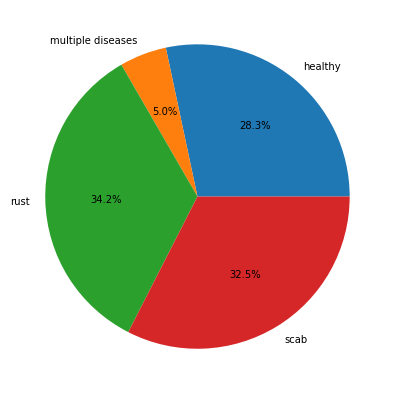

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))

label = ['healthy', 'multiple diseases', 'rust', 'scab']

plt.pie([len(healthy), len(multiple_diseases), len(rust), len(scab)],
        labels=label,
        autopct='%.1f%%');

 - 비율 차이가 커서 훈련/검증 데이터 나눌 때 비율 감안 필요

#### 이미지 출력

In [22]:
!pip install opencv-python==4.5.5.64

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60.5 MB 1.3 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.6.0.66
    Uninstalling opencv-python-4.6.0.66:
      Successfully uninstalled opencv-python-4.6.0.66
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [23]:
import matplotlib.gridspec as gridspec
import cv2

# 이미지 ID를 전달받아 출력하는 함수
def show_image(img_ids, rows=2, cols=3):
    assert len(img_ids) <= rows*cols # 이미지가 행*열 개수보다 많으면 오류발생
    
    plt.figure(figsize=(15, 8))
    grid = gridspec.GridSpec(rows, cols) # 서브플롯 배치 : grid[idx]로 축지정

    for idx, img_id in enumerate(img_ids):
        img_path = f'{data_path}images/{img_id}.jpg'
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax = plt.subplot(grid[idx])
        ax.imshow(image)

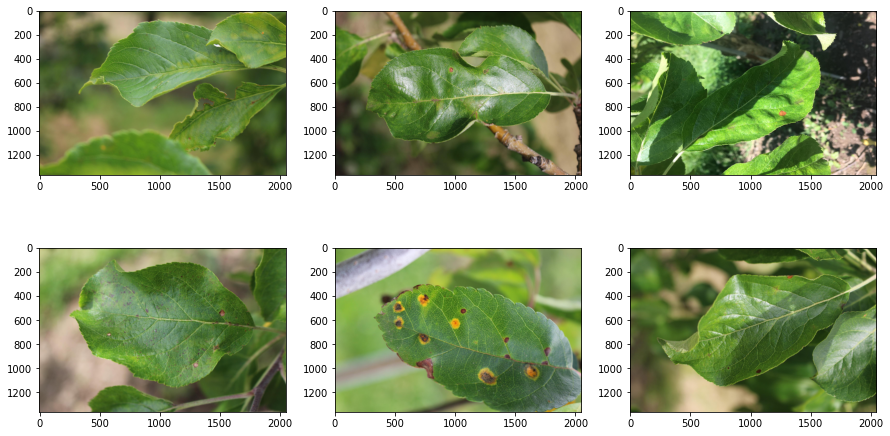

In [24]:
# last_healthy_img_ids = healthy['image_id'][-6:]
last_multiple_diseases_img_ids = multiple_diseases['image_id'][-6:]
show_image(last_multiple_diseases_img_ids)

## 베이스라인 모델
### 시드값 고정 및 GPU 장비 설정

In [25]:
import torch
import random
import numpy as np
import os

# 시드값 고정
## 이 모든 시드값 고정 코드가 반드시 필요한건 아니다(다른 환경에 다양하게 적용되도록 많은 시드 고정)
## 파이토치는 시드값 고정하더라도 해시값들에 의해 결과달라질수 있음
## 시드값 고정시 속도 저하 및 예측 성능 저하될 수 있음(결과를 재현할 필요 있을시에만 시드고정)
seed = 50
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)               # 파이썬 난수 생성기 시드 고정
np.random.seed(seed)            # 넘파이 난수 생성기 시드 고정
torch.manual_seed(seed)         # 파이토치 난수 생성기 시드 고정(CPU 사용시)
torch.cuda.manual_seed(seed)     # 파이토치 난수 생성기 시드 고정(GPU 사용시)
torch.cuda.manual_seed_all(seed) # 파이토치 난수 생성기 시드 고정(멀티GPU 사용시)
torch.backends.cudnn.deterministic= True    # 확정적 연산 사용
torch.backends.cudnn.benchmark= False       # 벤치마크 기능 해제
torch.backends.cudnn.enabled= False         # cudnn 사용 해제

#### GPU 장비 설정

In [26]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

device

device(type='cuda')

### 데이터 준비

In [27]:
import pandas as pd

# 데이터 경로
data_path = '/content/'

train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
submission = pd.read_csv('/content/sample_submission.csv')

#### 훈련 및 검증 데이터 분리

In [28]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(train, test_size=0.1,
                                stratify=train[['healthy', 'multiple_diseases', 'rust', 'scab']], # stratify : target(배열형식)
                                random_state=50) 

#### 데이터셋 클래스 정의(오버라이딩)
 - 이미 정해져 있는 클래스(추상클래스) Dataset을 상속받아서 : super().\__init__\()
 -  \__init__\(), \__len__\(), \__getitem__\() 세가지 오버라이딩

In [29]:
import cv2
from torch.utils.data import Dataset # 데이터 생성을 위한 클래스
import numpy as np

class ImageDataset(Dataset):
    # 초기화 메서드(생성자)
    def __init__(self, df, img_dir='./', transform=None, is_test=False):
        super().__init__()
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test

    # 데이터셋(인스턴스) 크기 반환 메서드
    def __len__(self):
        return len(self.df)
    
    # 인덱스(idx)에 해당하는 데이터 반환 메서드
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]               # 이미지 ID
        img_path = self.img_dir + img_id + '.jpg'   # 이미지 파일 경로
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 이미지 변환

        # 변환기가 있으면 이미지 데이터 변환적용
        if self.transform is not None:
            image = self.transform(image=image)['image'] # albumentations 모듈의 변환기 사용을 위한 형식 ['image']
        # 테스트 데이터면 → 이미지 데이터만 반환
        if self.is_test:
            return image
        # 훈련/검증용 데이터면 → 이미지 데이터 + 타깃값 반환
        else:
            # 타깃값 4개 중 가장 큰 값의 인덱스
            label = np.argmax(self.df.iloc[idx, 1:5])
            return image, label

#### 이미지 변환기 정의
 - albumentations가 제공하는 이미지 변환기
 - torchivsion 모듈에서 제공하는 이미지 변환기보다 빠르고 다양한 변환 제공

In [30]:
# module 'albumentations' has no attribute Error 발생시 github 통해서 설치
!pip install git+https://github.com/albumentations-team/albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-flcrr4c_
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-flcrr4c_
     |████████████████████████████████| 48.3 MB 125 kB/s 
  Created wheel for albumentations: filename=albumentations-1.2.1-py3-none-any.whl size=116794 sha256=e33d3edfab263e40cfacbb001331dc79b2b06a9d14ff4e9ce15632f58395516b
  Stored in directory: /tmp/pip-ephem-wheel-cache-dne8oh32/wheels/3a/25/ed/ec3b518e7a332d7f0a3bb37c280e1b784cf2f79b94b3c7d00b
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [31]:
# 이미지 변환을 위한 모듈 : ImportError 발생시 런타임 다시시작
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [32]:
# 훈련 데이터용 변환기
transform_train = A.Compose([A.Resize(450, 650),                                   # 이미지 크기 조절 (높이, 너비)
                             A.RandomBrightnessContrast(brightness_limit=0.2,       # 밝기 대비 조절
                                                        contrast_limit=0.2, p=0.3), # p : 적용확률
                             A.VerticalFlip(p=0.2),                                 # 상하 대칭 변환
                             A.HorizontalFlip(p=0.5),                               # 좌우 대칭 변환
                             A.ShiftScaleRotate(shift_limit=0.1,                    # 이동, 스케일링, 회전 변환
                                                scale_limit=0.2,
                                                rotate_limit=30, p=0.3),
                             A.OneOf([A.Emboss(p=1),                                # 양각화(Emboss), 날카로움, 블러 효과
                                      A.Sharpen(p=1),
                                      A.Blur(p=1)], p=0.3),
                             A.PiecewiseAffine(p=0.3),                              # 어파인 변환(이동, 확대/축소, 회전)
                             A.Normalize(),                                         # 정규화
                             ToTensorV2()])                                         # 텐서로 변환

In [33]:
# 검증 및 테스트 데이터용 변환기
transform_test = A.Compose([A.Resize(450, 650), # 크기는 당연히 훈련데이터와 맞춘다
                            A.Normalize(),      # 픽셀값 범위가 비슷해야(정규화) 비교가 쉽다
                            ToTensorV2()])      # 텐서로 변환

#### 데이터셋 및 데이터 로더 생성
 - 멀티프로세싱 활용 → 모델훈련 시간 단축
 - 데이터 로더는 전체 데이터에서 랜덤하게(설정시) 배치사이즈만큼 잘라서 오는데, 여러프로세스가 동시에 작업시 문제가 발생할 수도?
 - 조건 : 데이터 로더의 시드값 고정

  > seed_worker() 함수 정의

  > g = torch.Generator() 생성
  
  > g.manual_seed(0) 시드값 설정

  > DataLoader(**worker_init**=seed_worker, **generator**=g, **num_workers**=2)


In [34]:
# 데이터셋 정의(데이터셋 클래스의 인스턴스 생성)
img_dir = '/content/images/'

dataset_train = ImageDataset(train, img_dir=img_dir, transform=transform_train, is_test=False)
dataset_valid = ImageDataset(valid, img_dir=img_dir, transform=transform_test, is_test=False) # 검증용 데이터는 타깃값이 있으므로 False

In [35]:
dataset_train[0] # train 데이터중 첫번째의 (이미지 데이터, 타깃값)
# dataset_train[0][0] # 이미지 데이터
# dataset_train[0][1] # 타깃값

(tensor([[[ 0.9988,  0.9988,  0.9988,  ..., -1.3644, -1.3644, -1.3644],
          [ 0.9988,  0.9988,  0.9988,  ..., -1.3644, -1.3644, -1.3644],
          [ 0.9988,  0.9988,  0.9988,  ..., -1.3302, -1.3473, -1.3644],
          ...,
          [-0.0629, -0.1657, -0.0801,  ..., -1.5699, -1.5870, -1.5870],
          [-0.0801,  0.1254,  0.2796,  ..., -1.5870, -1.6042, -1.5870],
          [ 0.0227,  0.2796,  0.3138,  ..., -1.6042, -1.6042, -1.6042]],
 
         [[ 1.6057,  1.6408,  1.6057,  ..., -1.1253, -1.1253, -1.1253],
          [ 1.6057,  1.6408,  1.6408,  ..., -1.1253, -1.1253, -1.1253],
          [ 1.6232,  1.6408,  1.6408,  ..., -1.0903, -1.1078, -1.1253],
          ...,
          [ 0.4328,  0.3978,  0.5203,  ..., -1.4930, -1.5280, -1.5105],
          [ 0.5203,  0.7654,  0.8880,  ..., -1.4755, -1.4930, -1.4930],
          [ 0.6604,  0.8880,  0.9055,  ..., -1.5105, -1.5105, -1.5105]],
 
         [[-0.9504, -1.0898, -1.0898,  ..., -1.2990, -1.2990, -1.2990],
          [-1.0027, -1.1073,

In [36]:
# seed_worker() 함수 정의
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
# 제너레이터 생성
g = torch.Generator()
# 시드값 설정
g.manual_seed(0) # 설정이후 부터는 torch.rand()해도 같은 값 나옴

In [37]:
from torch.utils.data import DataLoader # 데이터 로더 생성을 위한 클래스

batch_size = 4 # 훈련데이터가 1821개로 많지 않아 배치크기 4로 작게 설정

loader_train = DataLoader(dataset_train, batch_size=batch_size,
                          shuffle = True, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)

loader_valid = DataLoader(dataset_train, batch_size=batch_size,
                          shuffle = True, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)

### 모델 생성
#### 사전 훈련 모델과 전이 학습
 - 파이토치로 사전 훈련 모델을 이용하는 방법 3가지

  > torchvision.models 모듈 이용 : 제공모델 수 적음

  > pretainedmodels 모듈 이용 : 테슬라 자율주행차 연구원이 만듦, 제공 모델 수 많음

  > 직접 구현한 모듈 이용 : EfficientNet 등

#### EfficientNet 모델 생성
 - 2019.5개발
 - Luke Melas-Kyriazi가 모듈로 구현
 - 상당히 깊은 신경망 모델 → 훈련/검증시간 길다
 - efficientnet-b0 ~ b7까지 있으며 b7의 성능이 가장 좋음
 - 캐글에서 'best single model'을 주제로한 토론 참고

In [38]:
!pip install efficientnet-pytorch==0.7.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=2ff3856375818d6b9d1e72c1f88242b066ce9a2361b7ae66e463e9346a389819
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [39]:
from efficientnet_pytorch import EfficientNet

In [40]:
# 사전 훈련된 efficientnet-b7 모델 불러오기
model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=4) # num_classes : 최종 출력값 개수, default=1,000

model = model.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth


  0%|          | 0.00/254M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b7


---
efficientnet-b7의 출력값 개수를 설정하는 또 다른 방법

 → 마지막 계층을 직접 수정



```
import torch.nn as nn

# 사전 훈련된 efficientnet-b7 모델 불러오기
model = EfficientNet.from_pretrained('efficientnet-b7')

# 불러온 efficientnet-b7 모델 마지막 계층(fully connected layer) 수정
model._fc = nn.Sequential(nn.Linear(model._fc.in_features, model._fc.out_features), # 2560 → 1000
                        nn.ReLU()
                        nn.Dropout(p=0.5),
                        nn.Linear(model._fc.out_features, 4)) # 1000 → 4
```
---


### 모델 훈련 및 성능 검증
 

#### 손실함수, 옵티마이저 설정
 - 손실함수 : CrossEntropyLoss() → 분류 문제
 - 옵티마이저 : AdamW(weight_decay) → 가중치 감쇠 파라미터 설정

In [41]:
import torch.nn as nn

# 손실 함수
criterion = nn.CrossEntropyLoss() # softmax + log 포함되어 있음
# 옵티마이저
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0006, weight_decay=0.0001)

훈련 및 성능 검증
 - 기존 : 모든 에폭만큼 훈련을 마친 뒤 성능 검증
 - 변경 : 매 에폭마다 검증(오래 걸리지만 훈련 상태 확인 가능)

In [42]:
from sklearn.metrics import roc_auc_score # ROC AUC 점수 계산 함수
from tqdm.notebook import tqdm # 진행상태 확인 : iterable 객체를 감싸서 사용

# 모델 저장할 디렉토리
PATH = '/content/drive/MyDrive/Colab Notebooks/kaggle/input/plan-pathology-2020-fgvc7/'

epochs = 1 # 시간관계상 1

# 모델 훈련에 오랜시간이 걸리므로, 훈련된 모델은 저장하여 계속 실행 되지 않도록 함
while not os.path.isfile(PATH+'model.pt'):
    # 총 에폭만큼 반복(한번의 에폭에서 훈련/검증 모두 수행하므로, 모델의 모드를 변경해줌)
    for epoch in range(epochs):
        # == [훈련]=====================================
        model.train()           # 모델을 훈련 상태로 설정
        epoch_train_loss = 0    # 에폭별 손실값 초기화(훈련 데이터용)

        # '반복 횟수'만큼 반복
        for images, labels in tqdm(loader_train):
            # 이미지, 레이블(타깃값) 데이터 미니배치를 장비에 할당
            images = images.to(device)
            labels = labels.to(device) # labels.shape : torch.size([4]) → 4는 미니배치 크기, 각 값은 잎사귀 병의 종류를 인덱스로 나타낸 값

            # 옵티마이저 내 기울기 초기화
            optimizer.zero_grad()
            # 순전파
            outputs = model(images) # outputs.shape : torch.size([4, 4]) → 미니배치크기, 각 병에 걸렸을 확률
            # 손실계산
            loss = criterion(outputs, labels) # outputs에 대한 softmax 처리해줌
            # 현재 배치에서의 손실 추가(훈련 데이터용)
            epoch_train_loss += loss.item()
            # 역전파
            loss.backward()
            # 가중치 갱신
            optimizer.step()
            # 스케쥴러 학습률 갱신
            # scheduler.step()
        # 훈련 데이터 손실값 출력
        print(f'에폭[{epoch+1}/{epochs}] - 훈련 데이터 손실값 : {epoch_train_loss/len(loader_train):.4f}')

        # == [검증]=====================================
        model.eval()            # 모델을 평가 상태로 설정
        epoch_valid_loss = 0    # 에폭별 손실값 초기화(검증 데이터용)
        preds_list = []         # 예측 확률값 저장용 리스트 초기화
        true_onehot_list = []   # 실제 타깃값 저장용 리스트 초기화

        with torch.no_grad():   # 기울기 계산 비활성화
            # 미니 배치 단위로 검증
            for image, labels in loader_valid:
                image = image.to(device)
                labels = labels.to(device)

                # 순전파
                outputs = model(image)
                # 손실계산
                loss = criterion(outputs, labels)
                # 현재 배치에서의 손실 추가(검증 데이터용)
                epoch_valid_loss += loss.item()

                # 예측 확률값
                preds = torch.softmax(outputs.cpu(), dim=1).numpy() # model내에서 softmax하지 않으므로 outputs를 cpu로 가져와서 softmax후 넘파이형식 변경
                # 실제 값
                true_onehot = torch.eye(4)[labels].cpu().numpy() # labels이 타깃값의 인덱스이므로 torch.eye[col_idx]개념으로 one-hot 인코딩 가능
                # 예측 확률값, 실제 값 저장
                preds_list.extend(preds)
                true_onehot_list.extend(true_onehot)
        # 검증 데이터 손실값 및 ROC AUC 점수 출력
        print(f'에폭 [{epoch+1}/{epochs}] - \
                검증 데이터 손실값 : {epoch_valid_loss/len(loader_valid):.4f} - \
                검증데이터 ROC AUC : {roc_auc_score(true_onehot_list, preds_list):.4f}')
        

    # 모델 전체 저장(파라미터만 저장 아님)
    
    torch.save(model, PATH+'model.pt')
    # 파라미터만 저장시 → 불러올때 모델의 클래스 선언(선언시의 파라미터 동일하게 전달)

# 모델 불러오기
model = torch.load(model, PATH+'model.pt')

In [43]:
torch.eye(4)

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])

In [44]:
a = torch.randint(0, 4, (4, ))

a.shape

torch.Size([4])

In [45]:
torch.eye(4)[a].numpy()

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]], dtype=float32)

In [46]:
torch.eye(4)[a].numpy().shape

(4, 4)

### 예측 및 결과 제출

In [47]:
# 테스트용 데이터셋 정의
dataset_test = ImageDataset(test, img_dir=img_dir,
                            transform=transform_test, is_test=True) # is_test=True인경우 image만 ㄱㄷ셔구
# 테스트용 데이터 로더 정의
loader_test = DataLoader(dataset_test, batch_size,
                         shuffle=False, worker_init_fn=seed_worker,
                         generator=g, num_workers=2)

#### 예측

In [48]:
model.eval() # 모델을 평가 상태로 설정

# 예측값 저장용 배열 초기화
preds = np.zeros((len(test), 4))

print('preds 초기화','---'*10)
print(preds)
print('---'*10)

with torch.no_grad():
    for i, images in tqdm(enumerate(loader_test)): # test데이터는 image만 리턴
        images = images.to(device)
        outputs = model(images)
        # 타깃 예측 확률
        preds_part = torch.softmax(outputs.cpu(), dim=1).numpy()
        preds[i*batch_size:(i+1)*batch_size] += preds_part

print('preds','---'*10)
print(preds)
print('---'*10)

preds 초기화 ------------------------------
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 ...
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
------------------------------


0it [00:00, ?it/s]

preds ------------------------------
[[0.25713092 0.254949   0.27685684 0.21106322]
 [0.23283066 0.24075352 0.28136533 0.24505048]
 [0.26360613 0.2352647  0.26440594 0.23672318]
 ...
 [0.23953161 0.25392592 0.28277013 0.22377227]
 [0.24973993 0.25410396 0.27493265 0.2212235 ]
 [0.24957602 0.24209248 0.29246956 0.21586195]]
------------------------------


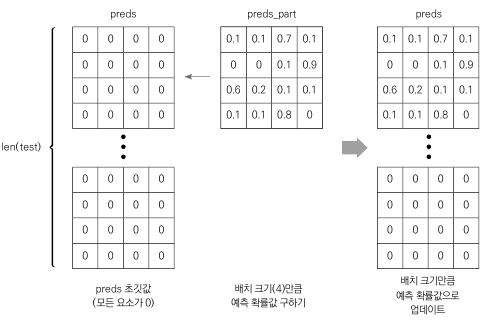

#### 결과 제출

In [49]:
submission[['healthy', 'multiple_diseases', 'rust', 'scab']] = preds
submission.to_csv('submission.csv', index=False)

## 성능 개선


---
[모델 훈련 및 성능 검증단계]
 - 1.에폭 늘리기
 - 2.스케쥴러 추가
---
[예측단계]
 - 3.TTA(테스트 단계 데이터 증강)기법
 - 4.레이블 스무딩 적용

### 모델 훈련 및 성능 검증

#### 스케줄러 설정
 - 훈련과정에서 학습률 조정
 - 훈련 초반에는 학습률이 큰게 좋다 → 빠르게 가중치 갱신
 - 훈련 진행하면서 점차 줄이면 → 최적의 가중치 찾기 수월


 - get_cosine_schedule_with_warmup() 스케줄러 : transformer 모듈에서 제공
  
  > 옵티마이저에서 지정한 학습률 만큼 증가 시켰다가 코사인 그래프 모양으로 점차 감소

In [50]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 7.4 MB/s 
     |████████████████████████████████| 6.6 MB 54.4 MB/s 
     |████████████████████████████████| 101 kB 13.9 MB/s 
     |████████████████████████████████| 596 kB 74.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [51]:
from transformers import get_cosine_schedule_with_warmup
epochs = 39 # 총 에폭

# 스케쥴러 생성
scheduler = get_cosine_schedule_with_warmup(optimizer,
                                            num_warmup_steps=len(loader_train)*3,   # len(loader_train) : 한 에포크에서 이터레이션 횟수
                                            num_training_steps=len(loader_train)*epochs)

 - 에폭수 증가(베이스라인 모델의 에폭수 : 5)
 - 앞서 정의한 옵티마이저(학습률 지정된) 전달
 - **스케쥴러를 통해 학습률은 매 이터레이션 마다(not epochs) 갱신 됨**
 - num_warmup_steps 파라미터 : 옵티마이저에서 지정한 학습률까지 도달하기 위한 이터레이션 횟수
 - num_training_steps 파라미터 : 훈련을 마치는데 필요한 반복횟수

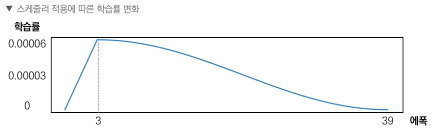

 - 가로축은 실제로 에폭이 아니라 훈련 이터레이션
 - 훈련 이터레이션 횟수 : 에폭 * len(loader_train)

### 예측
 - TTA 기법
 - 레이블 스무딩 기법

#### TTA(테스트 단계 데이터 증강, Test-Time Augmentation)
 - 일반적 경우 : 훈련된 모델이 테스트 데이터 원본을 활용해 타깃값 예측
 - TTA 적용한 경우 : 테스트 데이터를 여러 차례 변형한 뒤 예측(테스트 데이터 늘어난 효과)

  > 1.테스트 데이터에 여러 변환 적용

  > 2.변환된 테스트 데이터별로 타깃확률값 예측

  > 3.타깃 예측 확률의 평균 구함 → 앙상블 효과

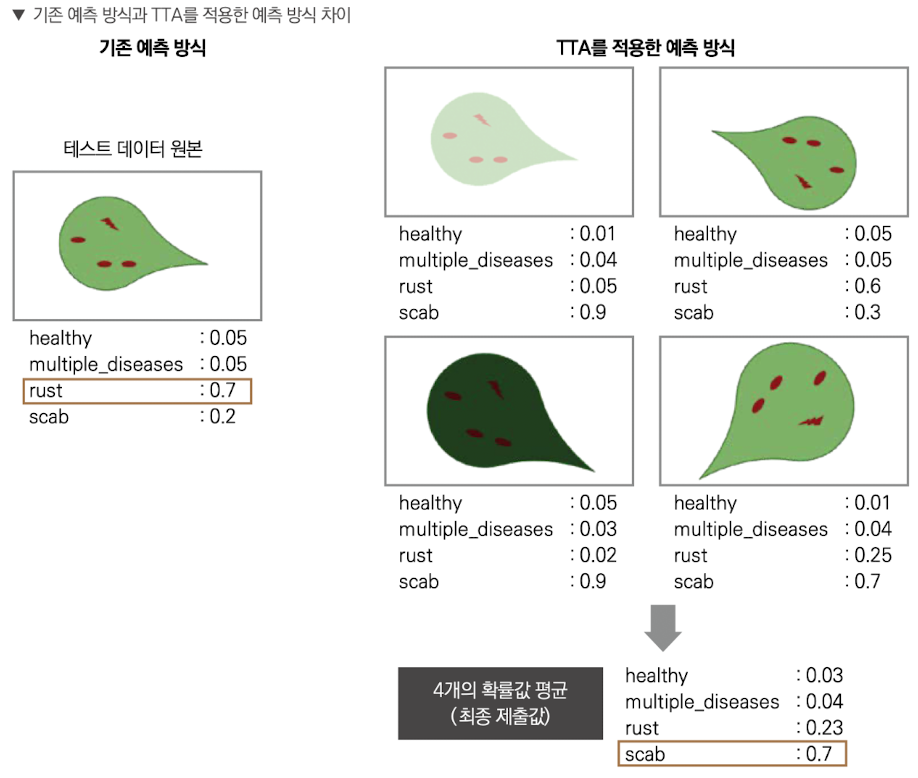

 - 원본으로만 예측 : rust일 확률 0.7로 가장 높음
 - TTA적용한 예측 : scab일 확률 0.7로 가장 높음

  > 다양한의견(변환적용된)을 종합하여 판단하는 효과

In [52]:
# 테스트 데이터 원본용 데이터셋 및 데이터 로더
dataset_test = ImageDataset(test, img_dir=img_dir,
                            transform=transform_test, # 테스트 데이터용 기본적인 변환만 적용
                            is_test=True) # ImageDataset클래스 오버라이딩시 is_test=True인 경우 이미지데이터만(타깃값 없이) return하도록 설정
loader_test = DataLoader(dataset_test, batch_size=batch_size,
                         shuffle=False, worker_init_fn=seed_worker,
                         generator=g, num_workers=2)                            

# TTA용 데이터셋 및 데이터 로더
dataset_TTA = ImageDataset(test, img_dir=img_dir,
                           transform=transform_train, # 훈련용데이터 변환기를 테스트 데이터에 적용(다양한 변환)
                           is_test=True)
loader_TTA = DataLoader(dataset_TTA, batch_size=batch_size,
                        shuffle=False, worker_init_fn=seed_worker,
                        generator=g, num_workers=2)

#### 예측
 - TTA 7번 수행 : 소요시간 대비 효과 고려

In [55]:
# num_TTA = 7 # TTA 횟수
num_TTA = 1 # 시간관계상 한번만 적용

preds_tta = np.zeros((len(test), 4)) # 예측값 저장용 배열 초기화(TTA용)

# TTA 적용해 예측
for i in range(num_TTA):
    with torch.no_grad():
        for i, images in tqdm(enumerate(loader_TTA)):
            images = images.to(device)
            outputs = model(images) # torch.size([4, 4]) 배치사이즈 * 4가지 각 병에 걸렸을 확률
            # 타깃 예측 확률
            preds_part = torch.softmax(outputs.cpu(), dim=1).numpy()
            preds_tta[i*batch_size:(i+1)*batch_size] += preds_part # 최종적으로 TTA 횟수 만큼 누적됨
            # TTA횟수 만큼 누적된 확률의 평균
            preds_tta /= num_TTA # /= : 나눈값으로 대체

0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61908ee200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61908ee200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

In [57]:
submission_tta = submission.copy() # 제출 샘플파일 복사
submission_tta[['healthy', 'multiple_diseases', 'rust', 'scab']] = preds_tta

#### 제출 파일 생성

In [59]:
submission_tta.to_csv('submission_tta.csv', index=False)

#### 레이블 스무딩
 - 과잉 확신하는 경우 : 특정 타깃값일 확률을 1에 매우 가깝게 예측
 - 확신이 과하면 일반화 성능이 떨어질 우려(최종 제출시 평가 점수 낮게 나올 수 있음)
 - 이러한 과잉 확신한 예측값을 보정하는 기법 : 레이블 스무딩

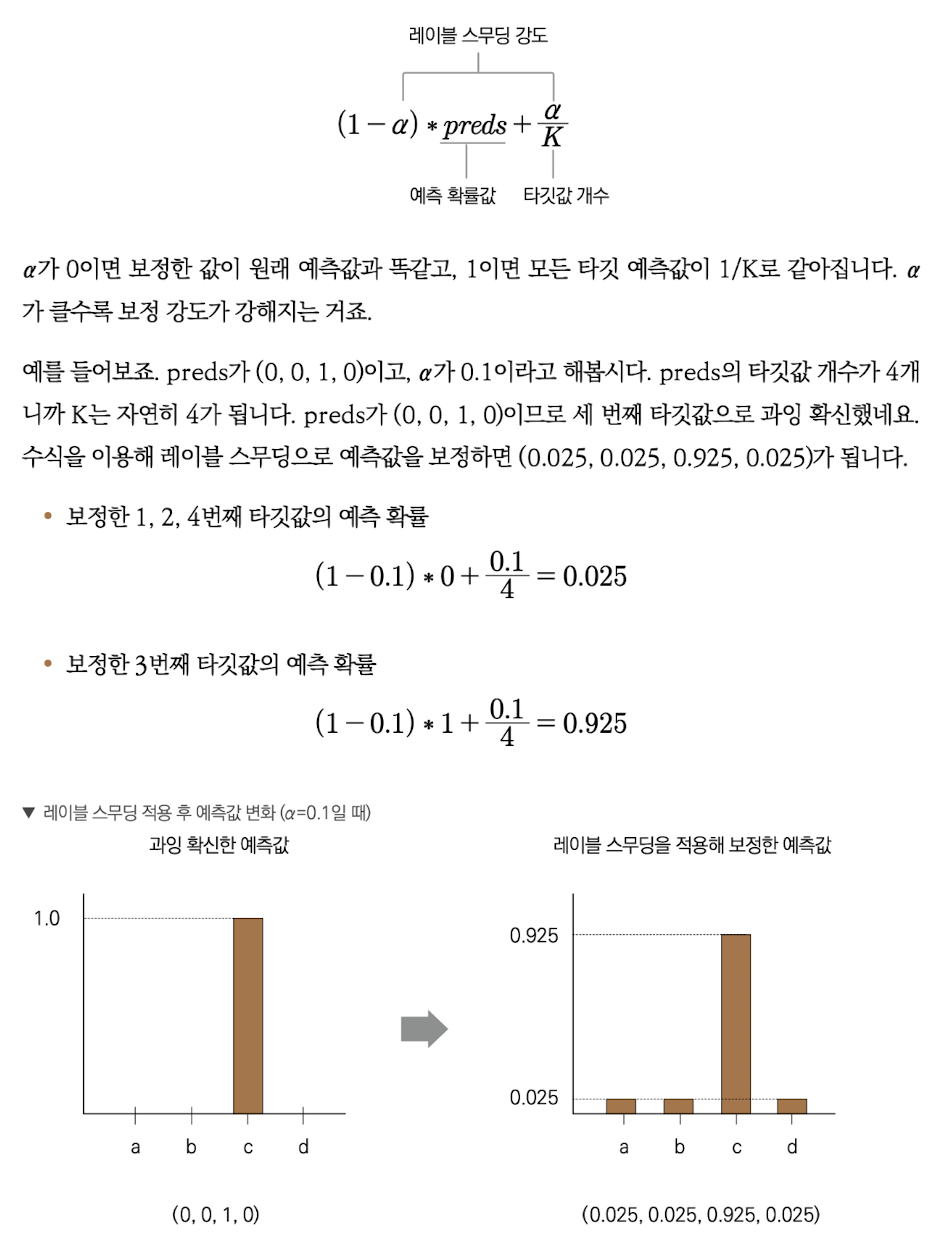

In [60]:
def apply_label_smoothing(df, target, alpha, threshold):
    # 타깃값 복사
    df_target = df[target].copy()
    k = len(target) # 타깃값 개수

    for idx, row in df_target.iterrows():
        if (row > threshold).any(): # any() : 하나라도 참이라면 True 반환
            row = (1 - alpha)*row + alpha/k
            df_target.iloc[idx] = row
    return df_target # 레이블 스무딩을 적용한 타깃값 반환

 - df : DataFrame
 - target : 타깃값 이름의 리스트
 - alpha : 레이블 스무딩 강도
 - threshold : 레이블 스무딩을 적용할 최솟값

In [61]:
alpha = 0.001 # 레이블 스무딩 강도
threshold = 0.999 # 레이블 스무딩을 적용할 임계값

# 레이블 스무딩 적용을 위한 DataFrame 복사
submission_tta_ls = submission_tta.copy()

target = ['healthy', 'multiple_diseases', 'rust', 'scab'] # 타깃값 열 이름

# 레이블 스무딩 적용
submission_tta_ls[target] = apply_label_smoothing(submission_tta_ls, target,
                                                  alpha, threshold)

submission_tta_ls.to_csv('submission_tta_ls.csv', index=False)

### 결과 제출 및 정리



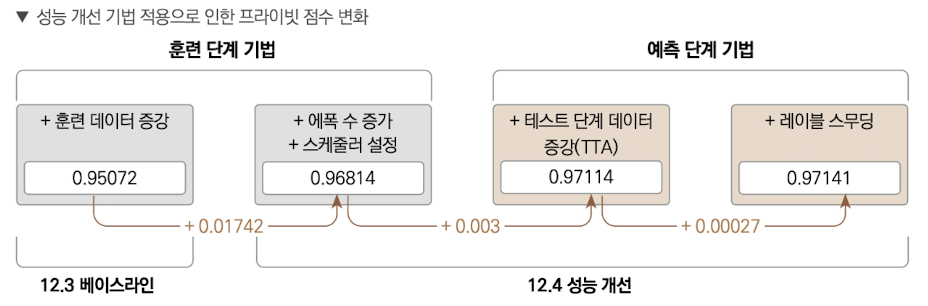